<a href="https://colab.research.google.com/github/arnavdesai6143/Datathon_TM126/blob/main/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setup, installations and importing the required modules
!pip install xlrd openpyxl -q
import numpy as np
import pandas as pd
from scipy import stats
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, List, Optional
from collections import defaultdict
import json


# **STAGE 1: DATA CLEANING AND PROCESSING**

We start with uploading the original CSV file given to us in the form of raw data. This is done so that we can manually clean any unnecesary information within that data, such as removal
of any duplicates, or imputing any missing values.
1. Missing values can be checked with the help of pandas and then can decide whether those values need to be dropped or can be replaced by their mean/median.
2. Outliers need to be dealt with (for example, a baseline heart rate of 400 bpm is biologically impossible and should be imputed)
3. Duplicate recordings can be dropped

In [ ]:
# Uploading the original CSV file given to us
from google.colab import files
print("Please upload your CTG.xls file:")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(f"File uploaded: {filename}")

Please upload your CTG.xls file:


Saving CTG.xls to CTG (2).xls
File uploaded: CTG (2).xls


In [ ]:
# Creating a comprehensive data cleaning class for CTG datasets with medical validation
class CTGDataCleaner:

    def __init__(self, verbose: bool = True):
        self.verbose = verbose
        self.cleaning_report = {}
        self.medical_thresholds = {
            # Physiological limits based on medical literature
            'LB': (50, 240),  # Baseline FHR absolute limits
            'LB_normal': (110, 160),  # Normal baseline range
            'AC': (0, 50),  # Accelerations per 20 min
            'UC': (0, 20),  # Uterine contractions per 20 min
            'FM': (0, 100),  # Fetal movements
            'ASTV': (0, 100),  # Abnormal short-term variability
            'ALTV': (0, 100),  # Abnormal long-term variability
            'mSTV': (0, 30),  # Mean STV
            'mLTV': (0, 50),  # Mean LTV
            'Width': (0, 300),  # Histogram width
            'Min': (50, 240),  # Minimum FHR
            'Max': (50, 240),  # Maximum FHR
            'Variance': (0, 1000),  # Variance of histogram
        }

    def load_and_prepare(self, data_path: str, sheet_name: Optional[str] = None) -> pd.DataFrame:
        """Load data with robust handling of different formats"""

        if data_path.endswith('.xls') or data_path.endswith('.xlsx'):
            # Handle Excel files
            xl_file = pd.ExcelFile(data_path)

            if sheet_name is None:
                # Auto-detect the best sheet
                for sheet in xl_file.sheet_names:
                    df_temp = pd.read_excel(xl_file, sheet_name=sheet, header=None, nrows=5)
                    # Check if this sheet has CTG features
                    if any('LB' in str(val) or 'NSP' in str(val)
                          for val in df_temp.values.flatten()):
                        sheet_name = sheet
                        break
                else:
                    sheet_name = xl_file.sheet_names[0]

            # Try different header rows
            for header_row in [0, 1, 2]:
                try:
                    df = pd.read_excel(data_path, sheet_name=sheet_name, header=header_row)
                    if 'NSP' in df.columns or any('NSP' in str(col) for col in df.columns):
                        break
                except:
                    continue
        else:
            df = pd.read_csv(data_path)

        self._log("Data loaded successfully", f"Shape: {df.shape}")
        return df

    def clean_column_names(self, df: pd.DataFrame) -> pd.DataFrame:
        """Standardize and clean column names"""
        df = df.copy()

        # Remove whitespace and standardize
        df.columns = [str(col).strip().replace(' ', '_') for col in df.columns]

        # Remove unnamed columns
        df = df.loc[:, ~df.columns.str.contains('^Unnamed', case=False)]

        # Standardize known variations
        column_mappings = {
            'MSTV': 'mSTV', 'mstv': 'mSTV',
            'MLTV': 'mLTV', 'mltv': 'mLTV',
            'nsp': 'NSP', 'Nsp': 'NSP',
            'TENDENCY': 'Tendency', 'tendency': 'Tendency',
            'LBE': 'LBE', 'lbe': 'LBE',
            'LB': 'LB', 'lb': 'LB',
            'AC': 'AC', 'ac': 'AC',
            'UC': 'UC', 'uc': 'UC',
            'DL': 'DL', 'dl': 'DL',
            'DS': 'DS', 'ds': 'DS',
            'DP': 'DP', 'dp': 'DP',
            'DR': 'DR', 'dr': 'DR',
            'FM': 'FM', 'fm': 'FM',
            'ASTV': 'ASTV', 'astv': 'ASTV',
            'ALTV': 'ALTV', 'altv': 'ALTV'
        }

        for old_name, new_name in column_mappings.items():
            if old_name in df.columns:
                df.rename(columns={old_name: new_name}, inplace=True)

        self._log("Column names cleaned", f"Total columns: {len(df.columns)}")
        return df

    def remove_leakage_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Remove features that leak target information"""

        # Known leakage columns from the original dataset
        leakage_cols = ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']

        # Also remove any column that has perfect correlation with NSP
        if 'NSP' in df.columns:
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            for col in numeric_cols:
                if col != 'NSP' and col in df.columns:
                    corr = df[col].corr(df['NSP'])
                    if abs(corr) > 0.95:  # Very high correlation suggests leakage
                        leakage_cols.append(col)

        cols_to_drop = [col for col in leakage_cols if col in df.columns]
        if cols_to_drop:
            df = df.drop(columns=cols_to_drop)
            self._log("Removed leakage columns", f"Dropped: {cols_to_drop}")

        return df

    def handle_duplicates(self, df: pd.DataFrame) -> pd.DataFrame:
        """Handle duplicate rows with medical logic"""

        initial_rows = len(df)

        # First remove exact duplicates
        df = df.drop_duplicates().reset_index(drop=True)

        # Check for near-duplicates (same patient measured twice)
        # If baseline and timing are very similar, might be duplicate recording
        if all(col in df.columns for col in ['LB', 'b', 'e']):
            # Create a signature for each recording
            df['temp_signature'] = (
                df['LB'].round(0).astype(str) + '_' +
                df['b'].round(0).astype(str) + '_' +
                df['e'].round(0).astype(str)
            )

            # Keep first occurrence of each signature
            df = df.drop_duplicates(subset=['temp_signature'], keep='first')
            df = df.drop(columns=['temp_signature'])

        removed = initial_rows - len(df)
        if removed > 0:
            self._log("Duplicates removed", f"Removed {removed} duplicate rows")

        return df.reset_index(drop=True)

    def validate_medical_ranges(self, df: pd.DataFrame) -> pd.DataFrame:
        """Validate and fix values based on medical knowledge"""

        corrections = {}

        for col, (min_val, max_val) in self.medical_thresholds.items():
            if col in df.columns:
                # Count out-of-range values
                out_of_range = (df[col] < min_val) | (df[col] > max_val)
                n_invalid = out_of_range.sum()

                if n_invalid > 0:
                    # Cap values at medical limits
                    df.loc[df[col] < min_val, col] = min_val
                    df.loc[df[col] > max_val, col] = max_val
                    corrections[col] = n_invalid

        if corrections:
            self._log("Medical range validation", f"Corrected: {corrections}")

        # Special validation for NSP
        if 'NSP' in df.columns:
            valid_nsp = df['NSP'].isin([1, 2, 3])
            if not valid_nsp.all():
                invalid_count = (~valid_nsp).sum()
                df = df[valid_nsp].reset_index(drop=True)
                self._log("Invalid NSP values removed", f"Removed {invalid_count} rows")

        return df

    def handle_missing_values(self, df: pd.DataFrame) -> pd.DataFrame:
        """Sophisticated missing value handling based on feature type"""

        missing_summary = {}

        for col in df.columns:
            if df[col].isna().any():
                n_missing = df[col].isna().sum()
                pct_missing = (n_missing / len(df)) * 100
                missing_summary[col] = {'count': n_missing, 'percentage': pct_missing}

                # Different strategies based on feature type and missingness
                if col == 'NSP':
                    # Can't impute target - remove these rows
                    df = df[df['NSP'].notna()]

                elif col in ['AC', 'UC', 'FM', 'DL', 'DS', 'DP', 'DR']:
                    # Event counts - missing likely means zero
                    df[col].fillna(0, inplace=True)

                elif col in ['LB', 'LBE']:
                    # Baseline - use median of normal range
                    normal_baseline = df[(df['LB'] >= 110) & (df['LB'] <= 160)]['LB'].median()
                    df[col].fillna(normal_baseline if not pd.isna(normal_baseline) else 135, inplace=True)

                elif pct_missing > 40:
                    # Too much missing - consider dropping column
                    df = df.drop(columns=[col])
                    self._log(f"Dropped column {col}", f"Missing: {pct_missing:.1f}%")

                elif col in ['ASTV', 'ALTV', 'mSTV', 'mLTV']:
                    # Variability metrics - use median grouped by NSP if available
                    if 'NSP' in df.columns:
                        for nsp_class in [1, 2, 3]:
                            mask = (df['NSP'] == nsp_class) & df[col].isna()
                            class_median = df[df['NSP'] == nsp_class][col].median()
                            df.loc[mask, col] = class_median
                    else:
                        df[col].fillna(df[col].median(), inplace=True)

                else:
                    # Default: median imputation for continuous
                    df[col].fillna(df[col].median(), inplace=True)

        if missing_summary:
            self._log("Missing values handled", f"Columns with missingness: {len(missing_summary)}")

        return df

    def detect_and_handle_outliers(self, df: pd.DataFrame, method: str = 'iqr') -> pd.DataFrame:
        """Detect and handle outliers using multiple methods"""

        outlier_summary = {}
        numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('NSP', errors='ignore')

        for col in numeric_cols:
            if col in df.columns:
                if method == 'iqr':
                    Q1 = df[col].quantile(0.25)
                    Q3 = df[col].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - 2.5 * IQR  # Less aggressive than typical 1.5
                    upper_bound = Q3 + 2.5 * IQR

                    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)

                elif method == 'zscore':
                    z_scores = np.abs(stats.zscore(df[col].dropna()))
                    outliers = z_scores > 4  # Very conservative threshold

                elif method == 'isolation':
                    # Use isolation forest for multivariate outlier detection
                    from sklearn.ensemble import IsolationForest
                    iso = IsolationForest(contamination=0.05, random_state=42)
                    outliers = iso.fit_predict(df[[col]].values) == -1

                n_outliers = outliers.sum()

                if n_outliers > 0:
                    outlier_summary[col] = n_outliers

                    # Handle based on feature type
                    if col in ['DP', 'DR']:  # Prolonged decelerations
                        # These outliers are clinically significant - keep them but flag
                        df[f'{col}_outlier'] = outliers.astype(int)

                    elif col in ['ASTV', 'ALTV'] and df.loc[outliers, col].mean() < 5:
                        # Very low variability is concerning - keep as is
                        df[f'{col}_low_flag'] = (df[col] < 5).astype(int)

                    else:
                        # Cap other outliers at percentiles
                        df.loc[outliers, col] = np.clip(
                            df.loc[outliers, col],
                            df[col].quantile(0.01),
                            df[col].quantile(0.99)
                        )

        if outlier_summary:
            self._log("Outliers handled", f"Features with outliers: {len(outlier_summary)}")

        return df

    def create_data_quality_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create features indicating data quality issues"""

        # Flag recordings with suspicious patterns
        df['quality_flag'] = 0

        # Check for flat traces (low variability across multiple metrics)
        if all(col in df.columns for col in ['ASTV', 'ALTV', 'Width', 'Variance']):
            flat_trace = (
                (df['ASTV'] < 5) &
                (df['ALTV'] < 10) &
                (df['Width'] < 20) &
                (df['Variance'] < 10)
            )
            df.loc[flat_trace, 'quality_flag'] = 1
            df['flat_trace_risk'] = flat_trace.astype(int)

        # Check for impossible combinations
        if 'LB' in df.columns and 'Min' in df.columns:
            impossible = df['Min'] > df['LB'] + 50  # Min shouldn't be way above baseline
            df.loc[impossible, 'quality_flag'] = 1

        # Recording duration quality
        if 'b' in df.columns and 'e' in df.columns:
            df['recording_duration'] = df['e'] - df['b']
            df['short_recording'] = (df['recording_duration'] < 10).astype(int)

        self._log("Data quality features created", "Added quality indicators")
        return df

    def balance_conversions(self, df: pd.DataFrame) -> pd.DataFrame:
        """Ensure consistent data types and handle mixed types"""

        for col in df.columns:
            if col == 'NSP':
                df[col] = df[col].astype(int)
            elif df[col].dtype == 'object':
                try:
                    # Try to convert to numeric
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                except:
                    # If it can't be converted, might need to encode or drop
                    unique_vals = df[col].nunique()
                    if unique_vals < 10:
                        # Categorical - encode
                        df[col] = pd.Categorical(df[col]).codes
                    else:
                        # Too many categories or text - drop
                        df = df.drop(columns=[col])

        return df

    def check_multicollinearity(self, df: pd.DataFrame, threshold: float = 0.95) -> pd.DataFrame:
        """Remove highly correlated features"""

        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if 'NSP' in numeric_cols:
            numeric_cols = numeric_cols.drop('NSP')

        corr_matrix = df[numeric_cols].corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        to_drop = []
        for column in upper_tri.columns:
            if any(upper_tri[column] > threshold):
                # Keep the feature with lower average correlation to all others
                col1_avg_corr = corr_matrix[column].mean()
                for idx, val in upper_tri[column].items():
                    if val > threshold:
                        col2_avg_corr = corr_matrix[idx].mean()
                        if col1_avg_corr > col2_avg_corr:
                            to_drop.append(column)
                        else:
                            to_drop.append(idx)

        to_drop = list(set(to_drop))
        if to_drop:
            df = df.drop(columns=to_drop)
            self._log("Multicollinearity handled", f"Dropped: {to_drop}")

        return df

    def final_validation(self, df: pd.DataFrame) -> pd.DataFrame:
        """Final validation and consistency checks"""

        # Ensure we have the target variable
        if 'NSP' not in df.columns:
            raise ValueError("Target variable 'NSP' not found in cleaned data")

        # Ensure minimum number of samples per class
        class_counts = df['NSP'].value_counts()
        min_samples = 10

        for cls in [1, 2, 3]:
            if cls not in class_counts or class_counts[cls] < min_samples:
                warnings.warn(f"Class {cls} has fewer than {min_samples} samples")

        # Remove any remaining NaN in target
        df = df[df['NSP'].notna()]

        # Ensure all features are numeric (except engineered categorical)
        non_numeric = df.select_dtypes(exclude=[np.number]).columns
        if len(non_numeric) > 0:
            self._log("Non-numeric columns remaining", list(non_numeric))

        # Sort by recording time if available
        if 'b' in df.columns:
            df = df.sort_values('b').reset_index(drop=True)

        self._log("Final validation complete", f"Final shape: {df.shape}")
        return df

    def _log(self, step: str, detail: str):
        """Internal logging function"""
        if self.verbose:
            print(f"[CLEANING] {step}: {detail}")
        self.cleaning_report[step] = detail

    def clean_pipeline(self, data_path: str, sheet_name: Optional[str] = None) -> Tuple[pd.DataFrame, Dict]:
        """
        Complete cleaning pipeline

        Returns:
            Tuple of (cleaned_dataframe, cleaning_report)
        """

        print("="*60)
        print("CTG DATA CLEANING PIPELINE")
        print("="*60)

        # 1. Load data
        df = self.load_and_prepare(data_path, sheet_name)

        # 2. Clean column names
        df = self.clean_column_names(df)

        # 3. Remove leakage features
        df = self.remove_leakage_features(df)

        # 4. Handle duplicates
        df = self.handle_duplicates(df)

        # 5. Validate medical ranges
        df = self.validate_medical_ranges(df)

        # 6. Handle missing values
        df = self.handle_missing_values(df)

        # 7. Detect and handle outliers
        df = self.detect_and_handle_outliers(df, method='iqr')

        # 8. Create data quality features
        df = self.create_data_quality_features(df)

        # 9. Balance conversions
        df = self.balance_conversions(df)

        # 10. Check multicollinearity
        df = self.check_multicollinearity(df, threshold=0.95)

        # 11. Final validation
        df = self.final_validation(df)

        print("="*60)
        print(f"CLEANING COMPLETE: {len(self.cleaning_report)} steps executed")
        print(f"Final dataset: {df.shape[0]} rows, {df.shape[1]} columns")
        print("="*60)

        return df, self.cleaning_report
    pass

In [ ]:
# Running the cleaner class
cleaner = CTGDataCleaner(verbose=True)
cleaned_df, report = cleaner.clean_pipeline(filename)

CTG DATA CLEANING PIPELINE
[CLEANING] Data loaded successfully: Shape: (2129, 46)
[CLEANING] Column names cleaned: Total columns: 42
[CLEANING] Removed leakage columns: Dropped: ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']
[CLEANING] Duplicates removed: Removed 128 duplicate rows
[CLEANING] Medical range validation: Corrected: {'UC': np.int64(1), 'FM': np.int64(29), 'mLTV': np.int64(1)}
[CLEANING] Invalid NSP values removed: Removed 1 rows
[CLEANING] Outliers handled: Features with outliers: 19
[CLEANING] Data quality features created: Added quality indicators
[CLEANING] Final validation complete: Final shape: (2000, 36)
CLEANING COMPLETE: 9 steps executed
Final dataset: 2000 rows, 36 columns


In [ ]:
# Exploring the cleaned data by printing the top 5 rows of the newly created dataset
cleaned_df.head()

,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,Mean,Median,Variance,Tendency,NSP,DP_outlier,quality_flag,flat_trace_risk,recording_duration,short_recording
0,0.0,1199.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,151.0,...,148.0,151.0,9.0,1.0,2,0,0,0,1199.0,0
1,0.0,718.0,4.0,100.0,3.0,3.0,0.0,1.0,0.0,130.0,...,127.0,133.0,43.0,0.0,1,1,0,0,718.0,0
2,0.0,1151.0,2.0,0.0,9.0,1.0,0.0,0.0,0.0,132.0,...,135.0,137.0,4.0,0.0,1,0,0,0,1151.0,0
3,0.0,871.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,132.0,...,134.0,136.0,2.0,1.0,1,0,0,0,871.0,0
4,0.0,3599.0,0.0,10.0,12.0,0.0,0.0,0.0,0.0,133.0,...,134.0,137.0,1.0,0.0,2,0,0,0,3599.0,0


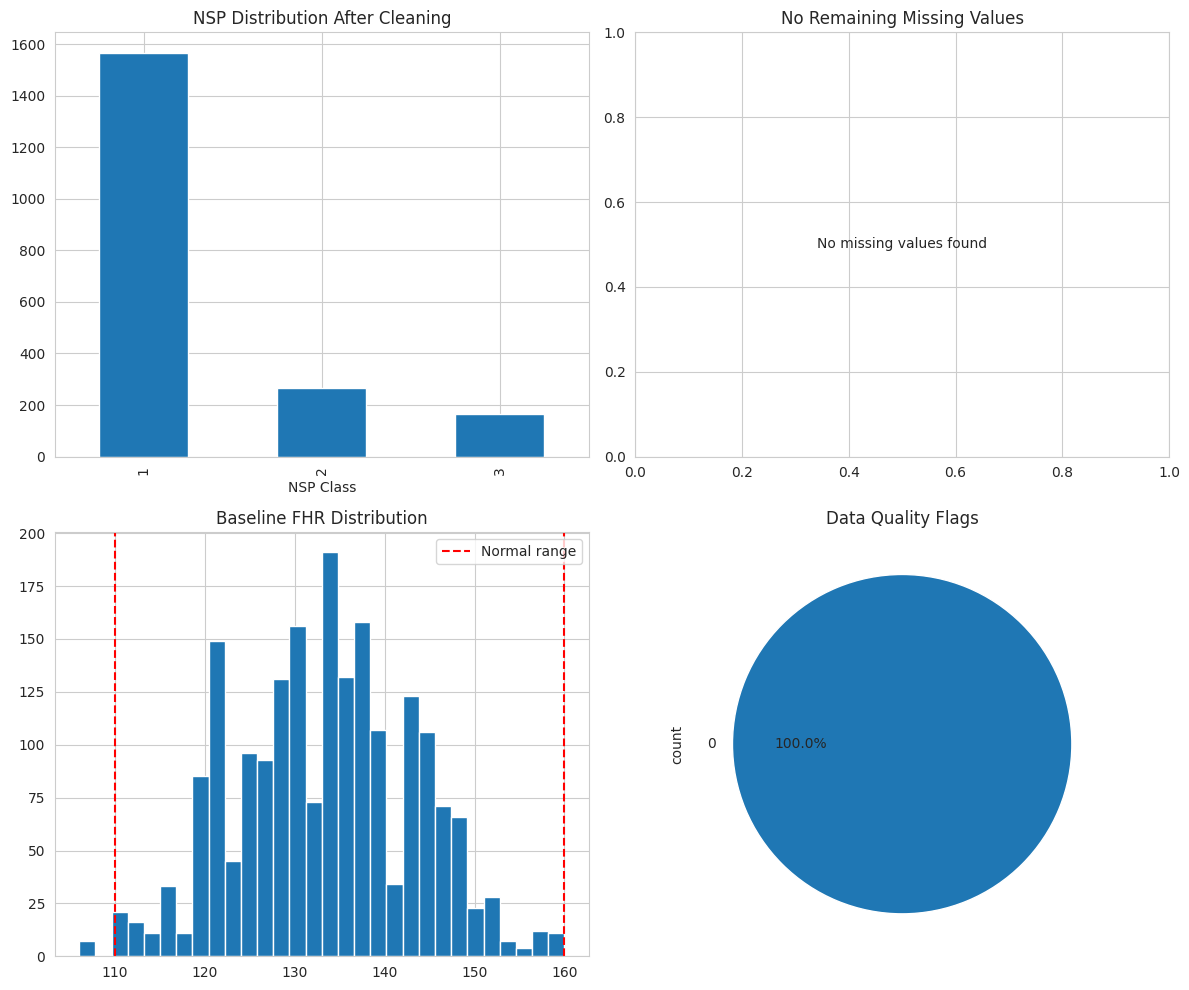

In [ ]:
# Visualising the cleaned results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Target distribution
cleaned_df['NSP'].value_counts().sort_index().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('NSP Distribution After Cleaning')
axes[0,0].set_xlabel('NSP Class')

# Plot 2: Missing values (if any remain)
missing = cleaned_df.isna().sum()
missing_to_plot = missing[missing > 0]
if not missing_to_plot.empty:
    missing_to_plot.plot(kind='barh', ax=axes[0,1])
    axes[0,1].set_title('Remaining Missing Values')
else:
    axes[0,1].set_title('No Remaining Missing Values')
    axes[0,1].text(0.5, 0.5, 'No missing values found',
                   horizontalalignment='center', verticalalignment='center',
                   transform=axes[0,1].transAxes)


# Plot 3: Feature distributions
if 'LB' in cleaned_df.columns:
    cleaned_df['LB'].hist(bins=30, ax=axes[1,0])
    axes[1,0].set_title('Baseline FHR Distribution')
    axes[1,0].axvline(110, color='r', linestyle='--', label='Normal range')
    axes[1,0].axvline(160, color='r', linestyle='--')
    axes[1,0].legend()

# Plot 4: Quality flags if created
if 'quality_flag' in cleaned_df.columns:
    quality_dist = cleaned_df['quality_flag'].value_counts()
    quality_dist.plot(kind='pie', ax=axes[1,1], autopct='%1.1f%%')
    axes[1,1].set_title('Data Quality Flags')

plt.tight_layout()
plt.show()

In [ ]:
# Saving the cleaned data into a new excel spreadsheet
cleaned_df.to_csv('ctg_cleaned.csv', index=False)
files.download('ctg_cleaned.csv')  # to download onto the computer

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Generating a cleaning report
print("\n CLEANING REPORT")
print("=" * 50)
for step, detail in report.items():
    print(f"✓ {step}: {detail}")


 CLEANING REPORT
✓ Data loaded successfully: Shape: (2129, 46)
✓ Column names cleaned: Total columns: 42
✓ Removed leakage columns: Dropped: ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']
✓ Duplicates removed: Removed 128 duplicate rows
✓ Medical range validation: Corrected: {'UC': np.int64(1), 'FM': np.int64(29), 'mLTV': np.int64(1)}
✓ Invalid NSP values removed: Removed 1 rows
✓ Outliers handled: Features with outliers: 19
✓ Data quality features created: Added quality indicators
✓ Final validation complete: Final shape: (2000, 36)


In [ ]:
# Check for any quality issues
if 'flat_trace_risk' in cleaned_df.columns:
    risk_cases = cleaned_df['flat_trace_risk'].sum()
    print(f"\n Warning: {risk_cases} cases with flat trace risk detected")

if 'quality_flag' in cleaned_df.columns:
    quality_issues = cleaned_df['quality_flag'].sum()
    print(f" Warning: {quality_issues} recordings with quality issues")

# **STAGE 2: EXPLORING THE RELATIONS**

The CTGRelationshipExplorer class performs Exploratory Data Analysis (EDA) on the cleaned CTG dataset, essentially investigating patterns and relationships in the data before building machine learning models.
1. It compares how each feature (ASTV, LB, AC, etc.) differs across Normal/Suspect/Pathologic cases.
2. Finds which features move together (e.g., accelerations and fetal movements)
3. Calculates which features are most predictive of fetal state
4. Looks for medically meaningful combinations like "flat trace pattern" (low variability = danger) and identifies "reassuring patterns" (normal baseline + accelerations = healthy).
5. Uses PCA to find dominant patterns across multiple features, uses clustering to see if data naturally groups into Normal/Suspect/Pathologic.

• The correlation heatmap shows which features are related. Red = positive correlation, blue = negative. Helps identify redundant features and clinical relationships.
• The ASTV Distribution depicts a histogram comparing variability patterns. Shows that pathologic cases cluster at low ASTV values.
• The Risk Pattern Analysis compares prevalence and pathologic rates of specific danger patterns (low ASTV, bradycardia, high decelerations).



In [ ]:
# creating a class for checking the medical relations and generating heatmaps
class CTGRelationshipExplorer:
    """Explore relationships and patterns in cleaned CTG data"""

    def __init__(self, df, target_col='NSP'):
        """
        Initialize with cleaned dataframe

        Parameters:
        df: Cleaned dataframe from CTGDataCleaner
        target_col: Name of target column (default: 'NSP')
        """
        self.df = df.copy()
        self.target_col = target_col
        self.numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(target_col, errors='ignore')
        self.insights = []

        # Define clinical feature groups for analysis
        self.feature_groups = {
            'baseline': ['LB', 'LBE'],
            'variability': ['ASTV', 'mSTV', 'ALTV', 'mLTV'],
            'accelerations': ['AC', 'FM'],
            'decelerations': ['DL', 'DS', 'DP', 'DR'],
            'contractions': ['UC'],
            'histogram': ['Width', 'Min', 'Max', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency']
        }

    def explore_all_relationships(self):
        """
        Run complete relationship exploration pipeline
        """
        print("="*80)
        print("CTG RELATIONSHIP EXPLORATION")
        print("="*80)

        # 1. Basic statistics by class
        try:
            self.explore_class_distributions()
        except Exception as e:
            print(f"⚠️ Class distribution analysis encountered an issue: {e}")

        # 2. Correlation analysis
        try:
            self.analyze_correlations()
        except Exception as e:
            print(f"⚠️ Correlation analysis encountered an issue: {e}")

        # 3. Feature-target relationships
        try:
            self.analyze_feature_target_relationships()
        except Exception as e:
            print(f"⚠️ Feature-target analysis encountered an issue: {e}")

        # 4. Clinical patterns
        try:
            self.discover_clinical_patterns()
        except Exception as e:
            print(f"⚠️ Clinical pattern discovery encountered an issue: {e}")

        # 5. Multivariate patterns
        try:
            self.explore_multivariate_patterns()
        except Exception as e:
            print(f"⚠️ Multivariate analysis encountered an issue: {e}")

        # 6. Generate visualizations
        try:
            self.create_comprehensive_visualizations()
        except Exception as e:
            print(f"⚠️ Visualization creation encountered an issue: {e}")

        # 7. Summary insights
        self.summarize_insights()

        return self.insights

    def explore_class_distributions(self):
        """
        Analyze how features differ across NSP classes
        """
        from scipy import stats
        import numpy as np

        print("\n📊 CLASS-WISE FEATURE ANALYSIS")
        print("-"*40)

        significant_features = []

        for feature in self.numeric_cols:
            if feature in self.df.columns:
                # Skip constant features
                if self.df[feature].nunique(dropna=True) <= 1:
                    continue

                # Group by NSP class
                groups = []
                for cls in [1, 2, 3]:
                    data = self.df[self.df[self.target_col] == cls][feature].dropna().values
                    if data.size > 0:
                        groups.append(data)

                # Skip if not enough groups
                if len(groups) < 2:
                    continue

                # Skip if all groups identical
                uniques = [np.unique(g) for g in groups]
                if all(len(u) == 1 for u in uniques) and len({u[0] for u in uniques}) == 1:
                    continue

                # Kruskal-Wallis test
                try:
                    h_stat, p_value = stats.kruskal(*groups)
                except ValueError as e:
                    if "All numbers are identical in kruskal" in str(e):
                        continue
                    else:
                        continue  # Skip feature on any other numerical issue

                if p_value < 0.001:
                    # Calculate effect size (eta-squared) safely
                    n = sum(len(g) for g in groups)
                    denom = max(n - len(groups), 1)
                    eta_squared = (h_stat - len(groups) + 1) / denom

                    # Get means for each class (aligning positions)
                    means = {}
                    for i, cls in enumerate([1, 2, 3]):
                        means[f"Class_{cls}"] = float(np.mean(groups[i])) if i < len(groups) else np.nan

                    significant_features.append({
                        'feature': feature,
                        'p_value': float(p_value),
                        'effect_size': float(eta_squared),
                        'means': means
                    })

        # Sort by effect size
        significant_features.sort(key=lambda x: x['effect_size'], reverse=True)

        # Report top features
        if significant_features:
            print("\nTop 10 Features that Distinguish Classes:")
            for i, feat in enumerate(significant_features[:10], 1):
                print(f"{i}. {feat['feature']}: Effect size = {feat['effect_size']:.3f}")
                print(f"   Normal: {feat['means'].get('Class_1', np.nan):.2f}, "
                      f"Suspect: {feat['means'].get('Class_2', np.nan):.2f}, "
                      f"Pathologic: {feat['means'].get('Class_3', np.nan):.2f}")

            # Key insight about variability
            try:
                if 'ASTV' in [f['feature'] for f in significant_features[:5]]:
                    astv_means = next(f for f in significant_features if f['feature'] == 'ASTV')['means']
                    if astv_means.get('Class_3', 0) < astv_means.get('Class_1', 0):
                        insight = "⚠️ KEY INSIGHT: Babies with low ASTV (short-term variability) are more likely to be pathologic"
                        self.insights.append(insight)
                        print(f"\n{insight}")
            except Exception:
                pass
        else:
            print("No statistically significant features found (this may indicate data issues)")

    def analyze_correlations(self):
        """
        Create and analyze correlation matrices
        """
        import numpy as np

        print("\n🔗 CORRELATION ANALYSIS")
        print("-"*40)

        # Filter out columns with no variance
        valid_cols = [c for c in self.numeric_cols if c in self.df.columns and self.df[c].nunique() > 1]
        if len(valid_cols) < 2:
            print("Not enough variable features for correlation analysis")
            return

        # Calculate correlation matrix with valid columns only
        try:
            corr_matrix = self.df[valid_cols].corr()
        except Exception as e:
            print(f"Correlation analysis failed: {e}")
            return

        # Find strong correlations
        strong_correlations = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if not np.isnan(corr_val) and abs(corr_val) > 0.6:
                    strong_correlations.append({
                        'feature1': corr_matrix.columns[i],
                        'feature2': corr_matrix.columns[j],
                        'correlation': float(corr_val)
                    })

        # Sort by absolute correlation
        strong_correlations.sort(key=lambda x: abs(x['correlation']), reverse=True)

        if strong_correlations:
            print("\nStrongest Feature Correlations:")
            for corr in strong_correlations[:10]:
                relationship = "increase together" if corr['correlation'] > 0 else "inversely related"
                print(f"• {corr['feature1']} & {corr['feature2']}: {corr['correlation']:.3f} ({relationship})")

        # Clinical pattern discovery
        try:
            if 'AC' in self.df.columns and 'FM' in self.df.columns:
                if self.df['AC'].nunique() > 1 and self.df['FM'].nunique() > 1:
                    ac_fm_corr = self.df[['AC', 'FM']].corr().iloc[0, 1]
                    if ac_fm_corr > 0.5:
                        insight = "📍 Accelerations and fetal movements tend to occur together (healthy sign)"
                        self.insights.append(insight)
                        print(f"\n{insight}")
        except Exception:
            pass

        # Deceleration patterns
        try:
            decel_cols = [col for col in ['DL', 'DS', 'DP', 'DR'] if col in self.df.columns]
            if len(decel_cols) > 1:
                decel_corr = self.df[decel_cols].corr()
                if (decel_corr > 0.4).sum().sum() > len(decel_cols):
                    insight = "📍 Different types of decelerations often occur together (concerning pattern)"
                    self.insights.append(insight)
                    print(f"\n{insight}")
        except Exception:
            pass

    def analyze_feature_target_relationships(self):
        """
        Analyze relationships between features and NSP classes
        """
        from sklearn.feature_selection import mutual_info_classif
        import numpy as np
        import pandas as pd

        print("\n🎯 FEATURE-TARGET RELATIONSHIPS")
        print("-"*40)

        # Mutual information scores (guard against constant features)
        use_cols = [c for c in self.numeric_cols if self.df[c].nunique() > 1]
        if len(use_cols) == 0:
            print("No variable numeric features for MI; skipping.")
        else:
            try:
                X = self.df[use_cols].fillna(self.df[use_cols].median(numeric_only=True))
                y = self.df[self.target_col].astype(int)
                mi_scores = mutual_info_classif(X, y, random_state=42)
                mi_df = pd.DataFrame({'feature': use_cols, 'mi_score': mi_scores}).sort_values('mi_score', ascending=False)

                print("\nTop 10 Features by Mutual Information with NSP:")
                for _, row in mi_df.head(10).iterrows():
                    print(f"• {row['feature']}: {row['mi_score']:.3f}")
            except Exception as e:
                print(f"Mutual information failed: {e}")

        # Specific pattern analysis
        try:
            self._analyze_variability_patterns()
        except Exception as e:
            print(f"⚠️ Variability patterns encountered an issue: {e}")

        try:
            self._analyze_deceleration_patterns()
        except Exception as e:
            print(f"⚠️ Deceleration patterns encountered an issue: {e}")

        try:
            self._analyze_baseline_patterns()
        except Exception as e:
            print(f"⚠️ Baseline pattern analysis encountered an issue: {e}")

    def _analyze_variability_patterns(self):
        """
        Deep dive into variability patterns
        """
        import numpy as np
        import pandas as pd

        var_cols = [col for col in ['ASTV', 'ALTV', 'mSTV', 'mLTV'] if col in self.df.columns]
        if not var_cols:
            return

        print("\n📈 Variability Pattern Analysis:")

        for col in var_cols:
            try:
                threshold = self.df[col].dropna().quantile(0.25)
                low_var = self.df[col] <= threshold
                crosstab = pd.crosstab(low_var.fillna(False), self.df[self.target_col], normalize='columns')

                if True in crosstab.index and 3 in crosstab.columns:
                    pathologic_pct = float(crosstab.loc[True, 3] * 100)
                    if pathologic_pct > 50:
                        insight = f"🔴 {pathologic_pct:.1f}% of pathologic cases have low {col} (≤{threshold:.2f})"
                        print(insight)
                        self.insights.append(insight)
            except Exception:
                continue

    def _analyze_deceleration_patterns(self):
        """
        Analyze deceleration patterns and their relationship with outcomes
        """
        import numpy as np

        decel_cols = [col for col in ['DL', 'DS', 'DP', 'DR'] if col in self.df.columns]
        if not decel_cols:
            return

        print("\n⚡ Deceleration Pattern Analysis:")

        try:
            # Total deceleration score
            self.df['total_decels'] = self.df[decel_cols].sum(axis=1)

            # Check relationship with NSP
            for nsp_class in [1, 2, 3]:
                vals = self.df[self.df[self.target_col] == nsp_class]['total_decels']
                if not vals.empty:
                    print(f"• Class {nsp_class} avg total decelerations: {vals.mean():.2f}")

            # High deceleration threshold
            high_decel_threshold = float(self.df['total_decels'].quantile(0.75))
            high_decels = self.df['total_decels'] > high_decel_threshold
            pathologic_rate = float(self.df[high_decels][self.target_col].value_counts(normalize=True).get(3, 0) * 100)

            if pathologic_rate > 30:
                insight = f"⚠️ {pathologic_rate:.1f}% of cases with high decelerations (>{high_decel_threshold:.0f}) are pathologic"
                print(insight)
                self.insights.append(insight)
        except Exception:
            pass

    def _analyze_baseline_patterns(self):
        """
        Analyze baseline heart rate patterns
        """
        import pandas as pd

        if 'LB' not in self.df.columns:
            return

        print("\n💓 Baseline Heart Rate Analysis:")

        try:
            # Define clinical categories
            self.df['baseline_category'] = pd.cut(
                self.df['LB'],
                bins=[0, 110, 160, 300],
                labels=['Bradycardia', 'Normal', 'Tachycardia']
            )

            # Cross-tabulation
            baseline_nsp = pd.crosstab(self.df['baseline_category'], self.df[self.target_col], normalize='index')

            print("\nBaseline vs NSP Distribution:")
            print((baseline_nsp.round(3) * 100).fillna(0))

            # Check bradycardia risk
            if 'Bradycardia' in baseline_nsp.index and 3 in baseline_nsp.columns:
                brady_path_rate = float(baseline_nsp.loc['Bradycardia', 3] * 100)
                if brady_path_rate > 20:
                    insight = f"🔴 Bradycardia (<110 bpm) shows {brady_path_rate:.1f}% pathologic rate"
                    print(insight)
                    self.insights.append(insight)
        except Exception:
            pass

    def discover_clinical_patterns(self):
        """
        Discover clinically meaningful patterns
        """
        import numpy as np

        print("\n🏥 CLINICAL PATTERN DISCOVERY")
        print("-"*40)

        # Pattern 1: Flat trace detection
        try:
            flat_trace_features = ['ASTV', 'ALTV', 'Width', 'Variance']
            available_flat = [f for f in flat_trace_features if f in self.df.columns]

            if len(available_flat) >= 3:
                # Create flat trace indicator using low quantiles
                flat_conditions = []
                for feat in available_flat:
                    q20 = self.df[feat].dropna().quantile(0.2)
                    flat_conditions.append(self.df[feat] <= q20)

                flat_trace = pd.concat(flat_conditions, axis=1).sum(axis=1) >= len(available_flat) - 1
                path_rate = float(self.df[flat_trace][self.target_col].value_counts(normalize=True).get(3, 0))

                if path_rate > 0.4:
                    insight = f"🚨 CRITICAL: Flat trace pattern (low variability across metrics) shows {path_rate*100:.1f}% pathologic rate"
                    print(insight)
                    self.insights.append(insight)
        except Exception:
            pass

        # Pattern 2: Reassuring pattern
        try:
            if all(col in self.df.columns for col in ['AC', 'LB']):
                reassuring = (
                    (self.df['AC'] > 2) &  # Has accelerations
                    (self.df['LB'] >= 110) & (self.df['LB'] <= 160)  # Normal baseline
                )

                if 'ASTV' in self.df.columns:
                    reassuring = reassuring & (self.df['ASTV'] > 10)  # Good variability

                normal_rate = float(self.df[reassuring][self.target_col].value_counts(normalize=True).get(1, 0))

                if normal_rate > 0.8:
                    insight = f"✅ Reassuring pattern (normal baseline + accelerations + good variability) shows {normal_rate*100:.1f}% normal rate"
                    print(insight)
                    self.insights.append(insight)
        except Exception:
            pass

    def explore_multivariate_patterns(self):
        """
        Explore complex multivariate patterns
        """
        import numpy as np
        import pandas as pd
        from sklearn.preprocessing import StandardScaler
        from sklearn.decomposition import PCA
        from sklearn.cluster import KMeans

        print("\n🔍 MULTIVARIATE PATTERN ANALYSIS")
        print("-"*40)

        # Guard: need at least two varying numeric features
        use_cols = [c for c in self.numeric_cols if c in self.df.columns and self.df[c].nunique() > 1]
        if len(use_cols) < 2:
            print("Not enough variable features for PCA/KMeans")
            return

        try:
            X_scaled = StandardScaler().fit_transform(self.df[use_cols].fillna(self.df[use_cols].median(numeric_only=True)))
        except Exception as e:
            print(f"Scaling failed: {e}")
            return

        # PCA to find dominant patterns
        try:
            n_components = min(5, X_scaled.shape[1], max(1, X_scaled.shape[0]-1))
            pca = PCA(n_components=n_components, random_state=42)
            pca_result = pca.fit_transform(X_scaled)

            print("\nPrincipal Component Analysis:")
            print(f"Variance explained by first {n_components} components: {pca.explained_variance_ratio_.sum():.1%}")

            # Top contributing features to PC1
            pc1_features = pd.DataFrame({
                'feature': use_cols,
                'loading': np.abs(pca.components_[0])
            }).sort_values('loading', ascending=False)

            print("\nTop features in PC1 (main variation pattern):")
            for _, row in pc1_features.head(5).iterrows():
                print(f"• {row['feature']}: {row['loading']:.3f}")
        except Exception as e:
            print(f"PCA failed: {e}")

        # Cluster-based pattern discovery
        try:
            kmeans = KMeans(n_clusters=3, random_state=42)
            clusters = kmeans.fit_predict(X_scaled)

            if self.target_col in self.df.columns:
                cluster_nsp = pd.crosstab(clusters, self.df[self.target_col], normalize='index')

                print("\nUnsupervised clusters vs NSP alignment:")
                for cluster_id in sorted(cluster_nsp.index):
                    dominant_class = cluster_nsp.loc[cluster_id].idxmax()
                    alignment = float(cluster_nsp.loc[cluster_id, dominant_class])
                    print(f"• Cluster {cluster_id}: {alignment:.1%} aligned with Class {dominant_class}")
        except Exception as e:
            print(f"KMeans clustering failed: {e}")

    def create_comprehensive_visualizations(self):
        """
        Create comprehensive visualization suite
        """
        import numpy as np
        import matplotlib.pyplot as plt
        import seaborn as sns
        from scipy import stats
        import pandas as pd

        try:
            # Set up the plotting style
            sns.set_style("whitegrid")
            plt.rcParams['figure.figsize'] = (20,16)

            fig = plt.figure(constrained_layout=True)
            gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.25)

            # Filter valid numeric columns (non-constant)
            valid_cols = [col for col in self.numeric_cols
                          if col in self.df.columns and self.df[col].nunique() > 1]

            # 1. Correlation heatmap
            ax1 = fig.add_subplot(gs[0:2, 0:2])
            if len(valid_cols) > 1:
                corr = self.df[valid_cols].corr()
                mask = np.triu(np.ones_like(corr), k=1)
                sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0,
                            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
                            ax=ax1, vmin=-1, vmax=1)
                ax1.set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
            else:
                ax1.text(0.5, 0.5, 'Insufficient variable features', ha='center', va='center')
                ax1.set_title('Correlation Heatmap (N/A)', fontsize=14)

            # 2. Top features by NSP
            ax2 = fig.add_subplot(gs[0, 2])
            top_features = ['ASTV', 'ALTV', 'AC', 'DP'] if all(f in self.df.columns for f in ['ASTV', 'ALTV', 'AC', 'DP']) else valid_cols[:4]
            if top_features:
                for feat in top_features:
                    means = [self.df[self.df[self.target_col] == cls][feat].mean() if feat in self.df.columns else np.nan
                             for cls in [1, 2, 3]]
                    ax2.plot([1, 2, 3], means, marker='o', label=feat, linewidth=2)
                ax2.set_xlabel('NSP Class')
                ax2.set_ylabel('Mean Value')
                ax2.set_title('Key Features by NSP Class', fontsize=12, fontweight='bold')
                ax2.legend(loc='best', fontsize=8)
                ax2.set_xticks([1, 2, 3])
                ax2.grid(True, alpha=0.3)
            else:
                ax2.text(0.5, 0.5, 'No features to plot', ha='center', va='center')

            # 3. Variability distribution by NSP
            ax3 = fig.add_subplot(gs[1, 2])
            if 'ASTV' in self.df.columns:
                for nsp_class in [1, 2, 3]:
                    class_data = self.df[self.df[self.target_col] == nsp_class]['ASTV'].dropna()
                    if not class_data.empty:
                        ax3.hist(class_data, alpha=0.5, label=f'Class {nsp_class}', bins=20)
                ax3.set_xlabel('ASTV (Short-term Variability)')
                ax3.set_ylabel('Frequency')
                ax3.set_title('ASTV Distribution by NSP', fontsize=12, fontweight='bold')
                ax3.legend()
                ax3.axvline(x=10, color='r', linestyle='--', alpha=0.5, label='Low var threshold')
            else:
                ax3.text(0.5, 0.5, 'ASTV not available', ha='center', va='center')

            # 4. Baseline vs Decelerations scatter
            ax4 = fig.add_subplot(gs[2, 0])
            if 'LB' in self.df.columns and any(col in self.df.columns for col in ['DP', 'DS']):
                decel_col = 'DP' if 'DP' in self.df.columns else 'DS'
                scatter = ax4.scatter(self.df['LB'], self.df[decel_col],
                                      c=self.df[self.target_col], cmap='RdYlGn_r',
                                      alpha=0.6, edgecolors='black', linewidth=0.5)
                ax4.set_xlabel('Baseline Heart Rate (LB)')
                ax4.set_ylabel(f'{decel_col} (Decelerations)')
                ax4.set_title('Baseline vs Decelerations', fontsize=12, fontweight='bold')
                ax4.axvline(x=110, color='g', linestyle='--', alpha=0.3)
                ax4.axvline(x=160, color='g', linestyle='--', alpha=0.3)
                plt.colorbar(scatter, ax=ax4, label='NSP Class')
            else:
                ax4.text(0.5, 0.5, 'LB and DP/DS not available', ha='center', va='center')

            # 5. Feature importance bar plot
            ax5 = fig.add_subplot(gs[2, 1:3])
            importance_scores = []
            for feat in valid_cols[:15]:  # Top 15 features
                try:
                    groups = [self.df[self.df[self.target_col] == cls][feat].dropna() for cls in [1, 2, 3]]
                    if all(len(g) > 0 for g in groups):
                        h_stat, _ = stats.kruskal(*groups)
                        importance_scores.append({'feature': feat, 'importance': float(h_stat)})
                except Exception:
                    continue

            if importance_scores:
                imp_df = pd.DataFrame(importance_scores).sort_values('importance', ascending=True).tail(10)
                ax5.barh(range(len(imp_df)), imp_df['importance'], color='steelblue')
                ax5.set_yticks(range(len(imp_df)))
                ax5.set_yticklabels(imp_df['feature'])
                ax5.set_xlabel('Kruskal-Wallis H-statistic')
                ax5.set_title('Top 10 Features by Statistical Importance', fontsize=12, fontweight='bold')
            else:
                ax5.text(0.5, 0.5, 'No valid features for KW importance', ha='center', va='center')

            # 6. Risk pattern identification
            ax6 = fig.add_subplot(gs[3, :])
            risk_patterns = []

            # Pattern 1: Low variability
            if 'ASTV' in self.df.columns:
                low_var = self.df['ASTV'] < 10
                risk_patterns.append({
                    'pattern': 'Low ASTV (<10)',
                    'count': int(low_var.sum()),
                    'pathologic_rate': float(self.df[low_var][self.target_col].value_counts(normalize=True).get(3, 0) * 100) \
                        if self.target_col in self.df.columns else 0.0
                })

            # Pattern 2: Bradycardia
            if 'LB' in self.df.columns:
                brady = self.df['LB'] < 110
                risk_patterns.append({
                    'pattern': 'Bradycardia (<110)',
                    'count': int(brady.sum()),
                    'pathologic_rate': float(self.df[brady][self.target_col].value_counts(normalize=True).get(3, 0) * 100) \
                        if self.target_col in self.df.columns else 0.0
                })

            # Pattern 3: High decelerations
            if 'DP' in self.df.columns:
                q75 = float(self.df['DP'].quantile(0.75))
                high_dp = self.df['DP'] > q75
                risk_patterns.append({
                    'pattern': f"High DP (>{q75:.1f})",
                    'count': int(high_dp.sum()),
                    'pathologic_rate': float(self.df[high_dp][self.target_col].value_counts(normalize=True).get(3, 0) * 100) \
                        if self.target_col in self.df.columns else 0.0
                })

            if risk_patterns:
                patterns_df = pd.DataFrame(risk_patterns)
                x = np.arange(len(patterns_df))
                width = 0.35

                ax6_2 = ax6.twinx()
                ax6.bar(x - width/2, patterns_df['count'], width, label='Count', color='skyblue')
                ax6_2.bar(x + width/2, patterns_df['pathologic_rate'], width, label='Pathologic %', color='coral')

                ax6.set_xlabel('Risk Patterns')
                ax6.set_ylabel('Count', color='skyblue')
                ax6_2.set_ylabel('Pathologic Rate (%)', color='coral')
                ax6.set_title('Clinical Risk Patterns Analysis', fontsize=12, fontweight='bold')
                ax6.set_xticks(x)
                ax6.set_xticklabels(patterns_df['pattern'], rotation=45, ha='right')
                ax6.legend(loc='upper left')
                ax6_2.legend(loc='upper right')
            else:
                ax6.text(0.5, 0.5, 'No patterns to display', ha='center', va='center')

            plt.suptitle('CTG Data Relationship Analysis', fontsize=16, fontweight='bold', y=0.995)
            plt.tight_layout(rect=[0, 0.01, 1, 0.99])
            plt.show()

            print("\n📊 Comprehensive visualizations created!")
        except Exception as e:
            print(f"\n⚠️ Visualization failed: {e}")
            print("Continuing with analysis...")

    def summarize_insights(self):
        """
        Summarize all discovered insights
        """
        print("\n" + "="*80)
        print("💡 KEY INSIGHTS SUMMARY")
        print("="*80)

        if not self.insights:
            print("No significant insights were discovered.")
            return

        # Deduplicate insights
        unique_insights = list(dict.fromkeys(self.insights))

        # Categorize insights
        critical_insights = [i for i in unique_insights if '🚨' in i or '🔴' in i]
        warning_insights = [i for i in unique_insights if '⚠️' in i or '⚡' in i]
        positive_insights = [i for i in unique_insights if '✅' in i or '📍' in i]

        if critical_insights:
            print("\n🔴 CRITICAL FINDINGS:")
            for insight in critical_insights:
                print(f"  {insight}")

        if warning_insights:
            print("\n⚠️ WARNING PATTERNS:")
            for insight in warning_insights:
                print(f"  {insight}")

        if positive_insights:
            print("\n✅ REASSURING PATTERNS:")
            for insight in positive_insights:
                print(f"  {insight}")

        print("\n" + "="*80)
        print(f"Total insights discovered: {len(unique_insights)}")
        print("="*80)

        return unique_insights

print("✅ Relationship Explorer class defined")


✅ Relationship Explorer class defined



STARTING COMPLETE CTG ANALYSIS PIPELINE

PHASE 1: DATA CLEANING
----------------------------------------
CTG DATA CLEANING PIPELINE
[CLEANING] Data loaded successfully: Shape: (2129, 46)
[CLEANING] Column names cleaned: Total columns: 42
[CLEANING] Removed leakage columns: Dropped: ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']
[CLEANING] Duplicates removed: Removed 128 duplicate rows
[CLEANING] Medical range validation: Corrected: {'UC': np.int64(1), 'FM': np.int64(29), 'mLTV': np.int64(1)}
[CLEANING] Invalid NSP values removed: Removed 1 rows
[CLEANING] Outliers handled: Features with outliers: 19
[CLEANING] Data quality features created: Added quality indicators
[CLEANING] Final validation complete: Final shape: (2000, 36)
CLEANING COMPLETE: 9 steps executed
Final dataset: 2000 rows, 36 columns

Cleaning complete!
   • Original shape: Shape: (2129, 46)
   • Final shape: (2000, 36)
   • Columns removed: 0

PHASE 2: RELATIONSHIP EXPLORATION
-----------------------

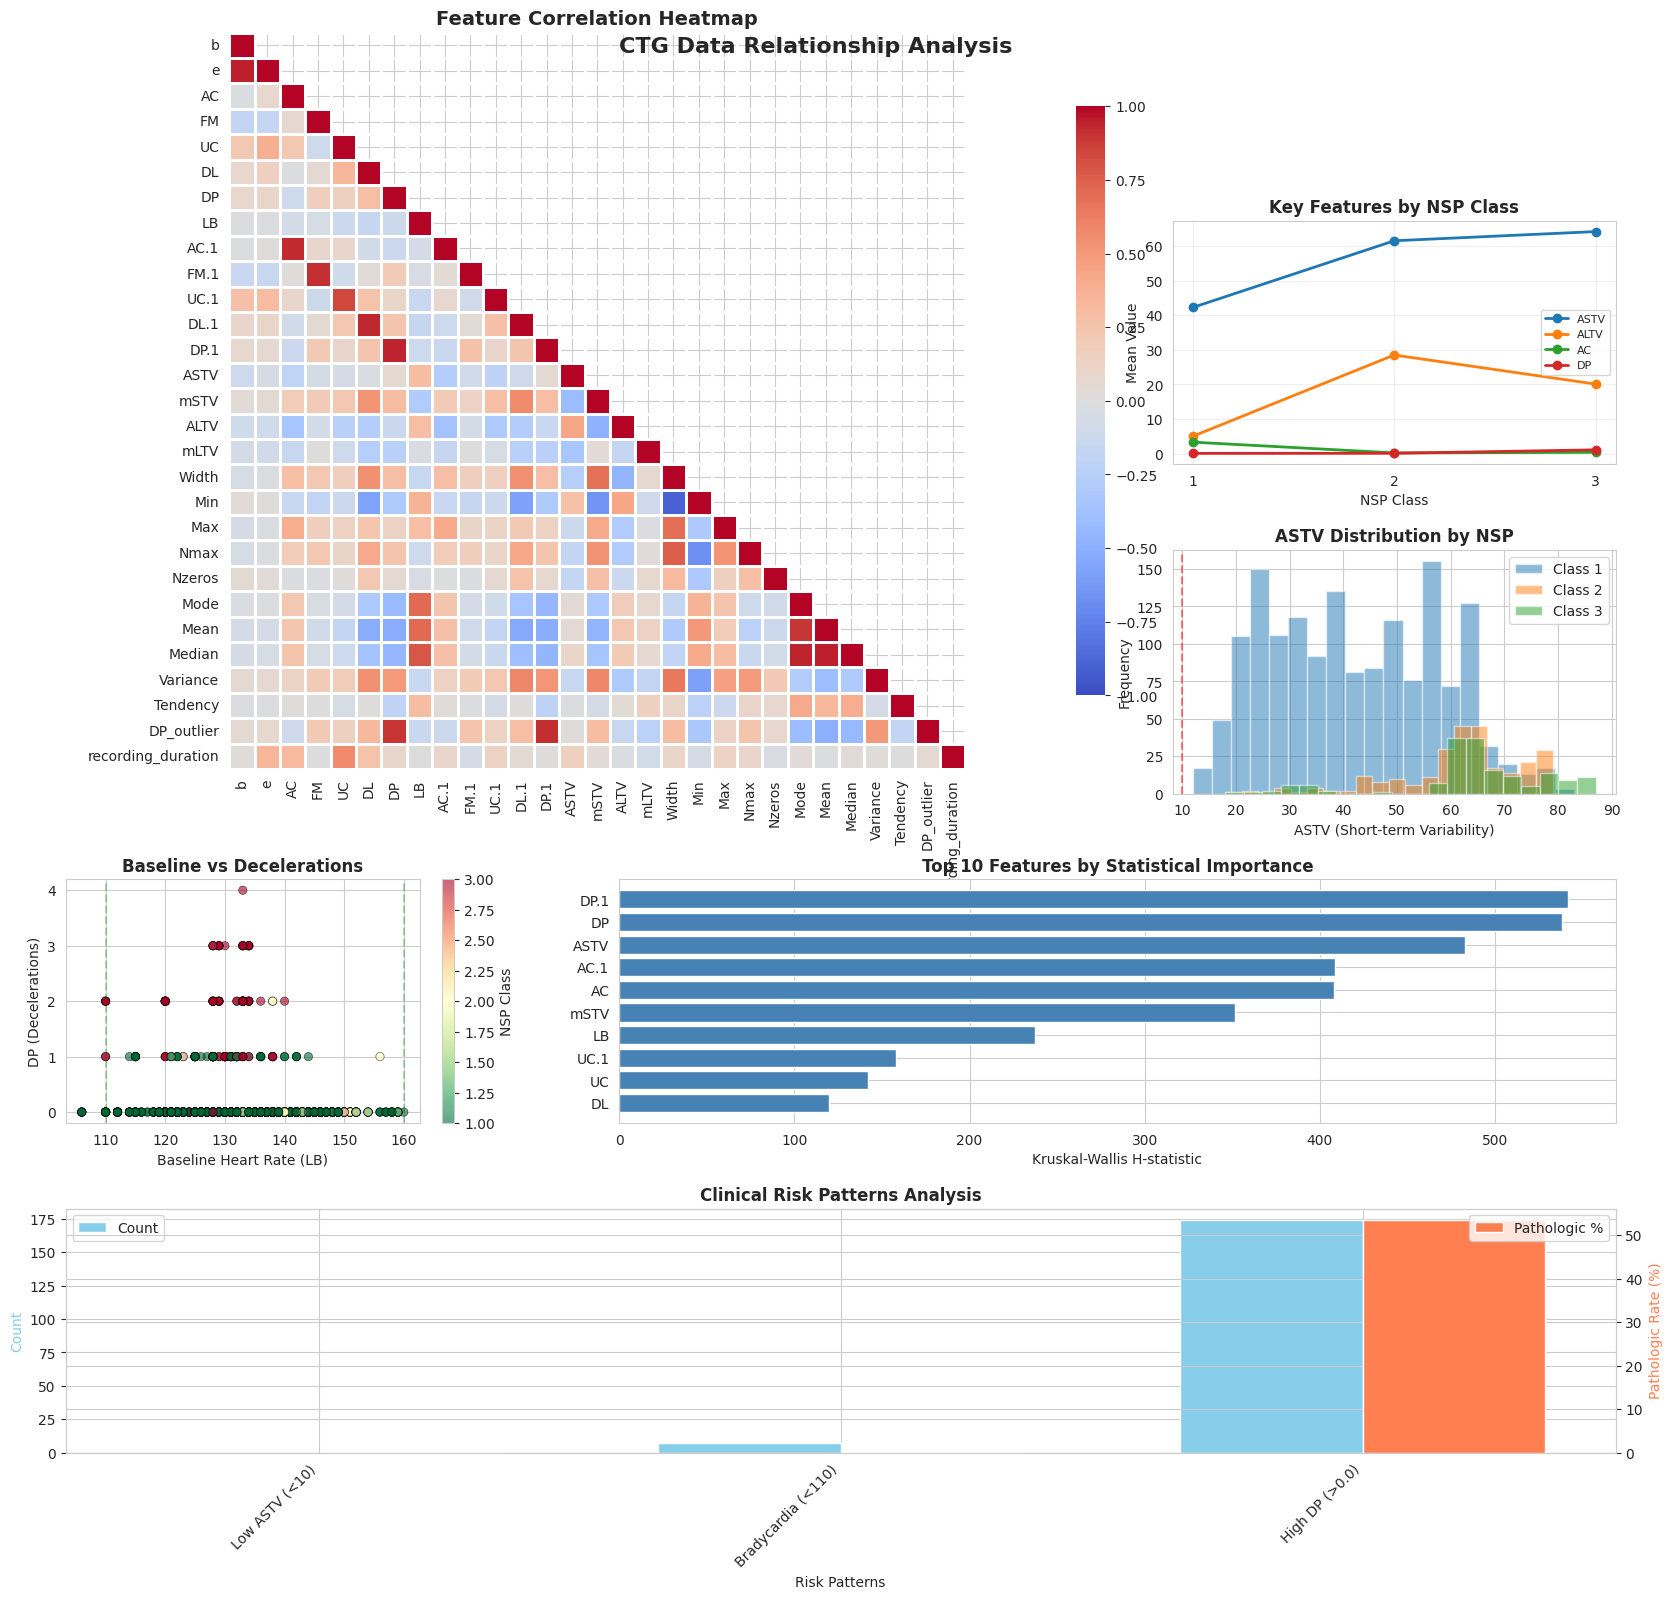

In [ ]:
print("\n" + "="*60)
print("STARTING COMPLETE CTG ANALYSIS PIPELINE")
print("="*60)

# STEP 1: Clean the data
print("\nPHASE 1: DATA CLEANING")
print("-"*40)
cleaner = CTGDataCleaner(verbose=True)
cleaned_df, cleaning_report = cleaner.clean_pipeline(filename)

print(f"\nCleaning complete!")
print(f"   • Original shape: {cleaning_report.get('Data loaded successfully', 'Unknown')}")
print(f"   • Final shape: {cleaned_df.shape}")
print(f"   • Columns removed: {len(cleaning_report.get('Dropped leakage columns', []))}")

# STEP 2: Explore relationships
print("\nPHASE 2: RELATIONSHIP EXPLORATION")
print("-"*40)
explorer = CTGRelationshipExplorer(cleaned_df)
insights = explorer.explore_all_relationships()

print(f"\nExploration complete!")
print(f"   • Insights discovered: {len(insights)}")

In [ ]:
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

# Data quality summary
print("\n1. Data Quality:")
print(f"   • Total samples: {len(cleaned_df)}")
print(f"   • Total features: {len(cleaned_df.columns)}")
print(f"   • Missing values: {cleaned_df.isna().sum().sum()}")

# Target distribution
print("\n2. NSP Distribution:")
nsp_counts = cleaned_df['NSP'].value_counts().sort_index()
for cls, count in nsp_counts.items():
    pct = (count / len(cleaned_df)) * 100
    print(f"   • Class {cls}: {count} samples ({pct:.1f}%)")

# Key risk patterns found
print("\n3. Key Risk Patterns Identified:")
risk_insights = [i for i in insights if '🔴' in i or '⚠️' in i]
for i, insight in enumerate(risk_insights[:5], 1):
    print(f"   {i}. {insight}")


FINAL SUMMARY

1. Data Quality:
   • Total samples: 2000
   • Total features: 36
   • Missing values: 0

2. NSP Distribution:
   • Class 1: 1568 samples (78.4%)
   • Class 2: 265 samples (13.2%)
   • Class 3: 167 samples (8.3%)

3. Key Risk Patterns Identified:
   1. 🔴 65.3% of pathologic cases have low ALTV (≤0.00)
   2. 🔴 67.1% of pathologic cases have low mLTV (≤4.47)
   3. 🔴 Bradycardia (<110 bpm) shows 21.4% pathologic rate


In [ ]:
cleaned_df.to_csv('ctg_cleaned.csv', index=False)
print("Saved: ctg_cleaned.csv")

# Save insights report
with open('ctg_analysis_report.txt', 'w') as f:
    f.write("CTG COMPLETE ANALYSIS REPORT\n")
    f.write("="*50 + "\n\n")

    f.write("DATA CLEANING SUMMARY:\n")
    f.write("-"*30 + "\n")
    for step, detail in cleaning_report.items():
        f.write(f"• {step}: {detail}\n")

    f.write("\n\nKEY INSIGHTS:\n")
    f.write("-"*30 + "\n")
    for insight in insights:
        f.write(f"• {insight}\n")

    f.write("\n\nFINAL STATISTICS:\n")
    f.write("-"*30 + "\n")
    f.write(f"Total samples: {len(cleaned_df)}\n")
    f.write(f"Total features: {len(cleaned_df.columns)}\n")
    f.write("\nNSP Distribution:\n")
    for cls, count in nsp_counts.items():
        f.write(f"  Class {cls}: {count}\n")

print("Saved: ctg_analysis_report.txt")

# Download files
files.download('ctg_cleaned.csv')
files.download('ctg_analysis_report.txt')

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("\nFiles downloaded:")
print("1. ctg_cleaned.csv - Cleaned dataset ready for modeling")
print("2. ctg_analysis_report.txt - Complete analysis report")

Saved: ctg_cleaned.csv
Saved: ctg_analysis_report.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


ANALYSIS COMPLETE!

Files downloaded:
1. ctg_cleaned.csv - Cleaned dataset ready for modeling
2. ctg_analysis_report.txt - Complete analysis report
